# Descripción del proyecto

En la compañía de extracción de petróleo OilyGiant. Nuestra tarea es encontrar los mejores lugares donde **abrir 200 pozos nuevos de petróleo**.

Para completar esta tarea, realizaremos los siguientes pasos:

- Leer los archivos con los parámetros recogidos de pozos petrolíferos en la región seleccionada: calidad de crudo y volumen de reservas.
- Crear un modelo para predecir el volumen de reservas en pozos nuevos.
- Elegir los pozos petrolíferos que tienen los valores estimados más altos.
- Elegir la región con el beneficio total más alto para los pozos petrolíferos seleccionados.

Tenemos datos sobre muestras de crudo de tres regiones. Ya se conocen los parámetros de cada pozo petrolero de la región. Crearemos un modelo que ayude a elegir la región con el mayor margen de beneficio. Analiza los beneficios y riesgos potenciales utilizando la técnica *bootstrapping*.

### Condiciones:

- Solo se debe usar la regresión lineal para el entrenamiento del modelo.
- Al explorar la región, se lleva a cabo un estudio de 500 puntos con la selección de los mejores 200 puntos para el cálculo del beneficio.
- El presupuesto para el desarrollo de 200 pozos petroleros es de 100 millones de dólares.
- Un barril de materias primas genera 4.5 USD de ingresos. El ingreso de una unidad de producto es de 4500 dólares (el volumen de reservas está expresado en miles de barriles).
- Después de la evaluación de riesgo, mantén solo las regiones con riesgo de pérdidas inferior al 2.5%. De las que se ajustan a los criterios, se debe seleccionar la región con el beneficio promedio más alto.

Los datos son sintéticos: los detalles del contrato y las características del pozo no se publican.

### Descripción de datos

Los datos de exploración geológica de las tres regiones se almacenan en archivos:

- `geo_data_0.csv`. [**Descarga el conjunto de datos**](https://practicum-content.s3.us-west-1.amazonaws.com/datasets/geo_data_0.csv)
- `geo_data_1.csv`. [**Descarga el conjunto de datos**](https://practicum-content.s3.us-west-1.amazonaws.com/datasets/geo_data_1.csv)
- `geo_data_2.csv`. [**Descarga el conjunto de datos**](https://practicum-content.s3.us-west-1.amazonaws.com/datasets/geo_data_2.csv)
- *id* — identificador único de pozo de petróleo
- *f0, f1, f2* — tres características de los puntos (su significado específico no es importante, pero las características en sí son significativas)
- *product* — volumen de reservas en el pozo de petróleo (miles de barriles).

### Dentro de los puntos a cumplir:
1. Descarga y prepara los datos. Explica el procedimiento.
2. Entrena y prueba el modelo para cada región en `geo_data_0.csv`:
    1. Divide los datos en un conjunto de entrenamiento y un conjunto de validación en una proporción de 75:25
    2. Entrena el modelo y haz predicciones para el conjunto de validación.
    3. Guarda las predicciones y las respuestas correctas para el conjunto de validación.
    4. Muestra el volumen medio de reservas predicho y *RMSE* del modelo.
    5. Analiza los resultados.
    6. Coloca todos los pasos previos en funciones, realiza y ejecuta los pasos 2.1-2.5 para los archivos 'geo_data_1.csv' y 'geo_data_2.csv'.
3. Prepárate para el cálculo de ganancias:
    1. Almacena todos los valores necesarios para los cálculos en variables separadas.
    2. Dada la inversión de 100 millones por 200 pozos petrolíferos, de media un pozo petrolífero debe producir al menos un valor de 500,000 dólares en unidades para evitar pérdidas (esto es equivalente a 111.1 unidades). Compara esta cantidad con la cantidad media de reservas en cada región.
    3. Presenta conclusiones sobre cómo preparar el paso para calcular el beneficio.
4. Escribe una función para calcular la ganancia de un conjunto de pozos de petróleo seleccionados y modela las predicciones:
    1. Elige los 200 pozos con los valores de predicción más altos de cada una de las 3 regiones (es decir, archivos 'csv').
    2. Resume el volumen objetivo de reservas según dichas predicciones. Almacena las predicciones para los 200 pozos para cada una de las 3 regiones.
    3. Calcula la ganancia potencial de los 200 pozos principales por región. Presenta tus conclusiones: propón una región para el desarrollo de pozos petrolíferos y justifica tu elección.
5. Calcula riesgos y ganancias para cada región:
    1. Utilizando las predicciones que almacenaste en el paso 4.2, emplea la técnica del bootstrapping con 1000 muestras para hallar la distribución de los beneficios.
    2. Encuentra el beneficio promedio, el intervalo de confianza del 95% y el riesgo de pérdidas. La pérdida es una ganancia negativa, calcúlala como una probabilidad y luego exprésala como un porcentaje.
    3. Presenta tus conclusiones: propón una región para el desarrollo de pozos petrolíferos y justifica tu elección. ¿Coincide tu elección con la elección anterior en el punto 4.3?

 ## Importando librerías

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



## Cargando datasets

In [2]:
geo0 = pd.read_csv('/datasets/geo_data_0.csv')
geo1 = pd.read_csv('/datasets/geo_data_1.csv')
geo2 = pd.read_csv('/datasets/geo_data_2.csv')

## Explorando el contenido de los datasets

#### Dataset "geo0"

In [3]:
print(geo0.info())
(geo0.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [4]:
geo0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


#### Dataset "geo1"

In [5]:
print(geo1.info())
(geo1.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [6]:
geo1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


#### Dataset "geo2"

In [7]:
print(geo2.info())
(geo2.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [8]:
geo2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


### Conociendo el contenido del dataset

**Podemos observar que tenemos tres datasets que describen la exploración geológica de las 3 regiones diferentes, observamos que los tres contienen 100,000 registros sin datos nulos**

**Respecto a las columnas:**


- *id* — identificador único de pozo de petróleo
- *f0, f1, f2* — tres características de los puntos (su significado específico no es importante, pero las características en sí son significativas)
- *product* — volumen de reservas en el pozo de petróleo (miles de barriles).


## Funciones

### Generando función para generar conjuntos de datos de entrenamiento y validación, así como escalado de datos

In [9]:
def split_data(df):
    #Dividiendo datos en conjunto de entrenamiento y validación
    df_train , df_valid= train_test_split(df, test_size=.25, random_state=1234)
    
    df_train_c = df_train.copy()
    df_valid_c = df_valid.copy()
    
    #Escalando datos mediante standard scaler
    numeric=['f0','f1','f2']
    scaler = StandardScaler()
    scaler.fit(df_train_c[numeric])
    
    
    df_train_c.loc[:,numeric]=scaler.transform(df_train_c[numeric])
    df_valid_c.loc[:,numeric]=scaler.transform(df_valid_c[numeric])
    
    #retornamos conjuntos de datos escalados en columnas numéricas
    return df_train_c , df_valid_c    

### Generando función para entrenar el modelo de regresión lineal

In [10]:
def gen_model(df_train,df_valid):
    #definiendo target y caractéristicas
    entity_col= 'id'
    target = 'product'
    features = [i for i in df_train.columns if i not in target + entity_col]
    
    #creando instancia del modelo de regresión lineal
    lr_model = LinearRegression()
    #entrenando el modelo
    lr_model.fit(df_train[features], df_train[target])
    #realizando predicciones
    predictions_valid = lr_model.predict(df_valid[features])
    
    #retornamos las predicciones y la columna target del conjunto de validación
    return predictions_valid, df_valid[target]

### Generando función para el volumen medio de reservas predicho y RMSE 

In [11]:
def metrics(model_predictions, target_valid):
    #calculando la media de las predicciones
    mean = model_predictions.mean()
    #calculando el error medio cuadrático
    mse = mean_squared_error(target_valid,model_predictions)
    #calculando la raíz del error medio cuadrático
    rmse = mse ** .5
    
    #retornando la media y la raíz del error medio cuadrático
    return mean , rmse 

## Llamando a las funciones para realizar cálculos con el modelo de predicción

In [14]:
df_train_0,df_valid_0 = split_data(geo0)
lr_model0_predictions,target_valid0 = gen_model(df_train_0,df_valid_0)
mean_geo0, rmse_geo0= metrics(lr_model0_predictions,target_valid0)
df_new_valid0 = df_valid_0.copy()
df_new_valid0['predictions'] = lr_model0_predictions


print("El volumen medio de reservas predicho es de: ",round(mean_geo0,3), "(Miles de barriles)")
print("El Error medio cuadrático para las estimaciones es:  ", rmse_geo0)


El volumen medio de reservas predicho es de:  92.43 (Miles de barriles)
El Error medio cuadrático para las estimaciones es:   37.562394183637785


In [31]:
df_train_1,df_valid_1 = split_data(geo1)
lr_model1_predictions, target_valid1 = gen_model(df_train_1,df_valid_1)
mean_geo1, rmse_geo1= metrics(lr_model1_predictions,target_valid1)
df_new_valid1 = df_valid_1.copy()
df_new_valid1['predictions'] = lr_model1_predictions


print("El volumen medio de reservas predicho es de: ",round(mean_geo1,3), "(Miles de barriles)")
print("El Error medio cuadrático para las estimaciones es:  ",rmse_geo1)

El volumen medio de reservas predicho es de:  68.802 (Miles de barriles)
El Error medio cuadrático para las estimaciones es:   0.8939344738117704


In [32]:
df_train_2,df_valid_2 = split_data(geo2)
lr_model2_predictions , target_valid2 = gen_model(df_train_2,df_valid_2)
mean_geo2, rmse_geo2= metrics(lr_model2_predictions,target_valid2)

df_new_valid2 = df_valid_2.copy()
df_new_valid2['predictions'] = lr_model2_predictions


print("El volumen medio de reservas predicho es de: ",round(mean_geo2,3) , "(Miles de barriles)")
print("El Error medio cuadrático para las estimaciones es: ",rmse_geo2)


El volumen medio de reservas predicho es de:  94.916 (Miles de barriles)
El Error medio cuadrático para las estimaciones es:  40.10318099258418


**Resumiendo datos previos:**

**Geozona 0:**

El **volumen medio** de reservas predicho es de:  92.43 (Miles de barriles)

El **Error medio cuadrático** para las estimaciones es:   37.562394183637785

**Geozona 1:**

El **volumen medio** de reservas predicho es de:  68.802 (Miles de barriles)

El **Error medio cuadrático** para las estimaciones es:   0.8939344738117704

**Geozona 2:**

El **volumen medio** de reservas predicho es de:  94.916 (Miles de barriles)

El **Error medio cuadrático** para las estimaciones es:  40.10318099258418

In [33]:
#Datos de negocio
income_per_unit=4500
risk_thres=0.025
cost_200_wells = 100000000 #(100M)
cost_per_well = cost_200_wells / 200 #(500K)
breakeven = 111.1  #(Cantidad de barriles para evitar perdidas )


## Función para calcular la ganancia de un conjunto de pozos


In [34]:
def compute_gains(df,
                  prediction_col='predictions',
                  product_col = 'product',
                  income_per_unit=income_per_unit,
                  cost_200_wells=cost_200_wells,
                  print_result=False
                 ):
    
    df_ordered= df.sort_values(by=prediction_col, ascending=False)
    top_200_wells = df_ordered.head(200)
    estimated_revenue = top_200_wells[prediction_col].sum() * income_per_unit
    estimated_profit = estimated_revenue - cost_200_wells
    
    if print_result == True:
        print(f"""
        Volumen medio predicho (en miles de barriles): {round(top_200_wells[prediction_col].mean(),4)}
        Volumen medio real (en miles de barriles): {round(top_200_wells[product_col].mean(),4)}
        Ingresos estimados (Millones de dólares) : {round(estimated_revenue,4)} 
        Ganancia estimada (Millones de dólares) : { round(estimated_profit,4)}
        **********************
        """)
    return estimated_profit 

In [35]:
c=-1
for df in [df_new_valid0,df_new_valid1,df_new_valid2]:
    c+=1
    print("Geozona:",c )
    compute_gains(df,print_result=True)

Geozona: 0

        Volumen medio predicho (en miles de barriles): 154.2457
        Volumen medio real (en miles de barriles): 149.1558
        Ingresos estimados (Millones de dólares) : 138821157.441 
        Ganancia estimada (Millones de dólares) : 38821157.441
        **********************
        
Geozona: 1

        Volumen medio predicho (en miles de barriles): 138.6943
        Volumen medio real (en miles de barriles): 137.9454
        Ingresos estimados (Millones de dólares) : 124824861.686 
        Ganancia estimada (Millones de dólares) : 24824861.686
        **********************
        
Geozona: 2

        Volumen medio predicho (en miles de barriles): 149.9817
        Volumen medio real (en miles de barriles): 139.4995
        Ingresos estimados (Millones de dólares) : 134983487.0497 
        Ganancia estimada (Millones de dólares) : 34983487.0497
        **********************
        


### Métricas de negocio
**Ingreso**:

El cálculo del ingreso se realiza mediante la multiplicación del total de Miles de barriles obtenidos en los 200 pozos por el ingreso unitario (4500 dolares)

**Beneficio / Ganancia**:

Se cálcula mediante la resta de los ingresos menos el coste de los bienes (inversión)

**Punto de quiebre / breakeven:**
Se refiere a la cantidad mínima de ventas (ingresos) que debemos tener para evitar pérdidas, en este caso :
    
* Dada la inversión de 100 millones por 200 pozos petrolíferos, de media un pozo petrolífero debe producir al menos un valor de 500,000 dólares en unidades para evitar pérdidas (esto es equivalente a 111.1 unidades)
* Comparamos el punto de quiebre ( 111.1 unidades ) en relación al volumen medio predicho.

### Conclusiones y propuesta de región prospecto:
Con base a los resultados obtenidos anteriormente, considerando las siguientes variables:
* Volumen medio predicho (en miles de barriles)
* Volumen medio real (en miles de barriles)
* Ingresos estimados 
* Ganancia estimada 

Podemos concluir que al momento, la mejor Geozona para invertir es la Región 0 (" Geozona 0"/ geo_data_0.csv ) debido a que cuenta con:
* **Volumen medio predicho (en miles de barriles) : 154.245**
* **Volumen medio real (en miles de barriles) : 149.155**
* **Ingresos estimados (Millones de dólares): 138,821,157.44**
* **Ganancia estimada (Millones de dólares): 38,821,157.441**

## Calculando riesgos y ganancias para cada región:



Region_0
Intervalo de confianza del 95% entre el rango de: 3195304.4 y 3336321.91  millones de dolares
Porcentaje de riesgo de pérdida : 0.1 %
Beneficio medio para la región 3265813.16


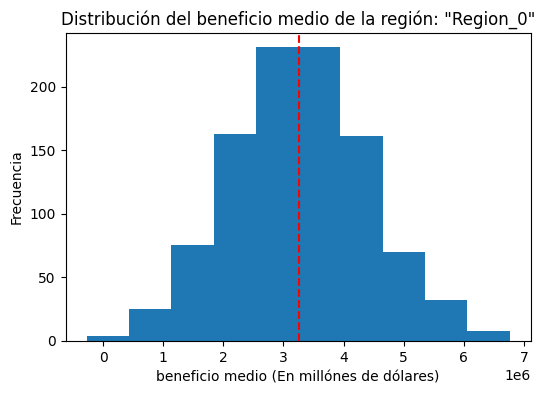

----------------------------------------------------

Region_1
Intervalo de confianza del 95% entre el rango de: 4074066.69 y 4317449.36  millones de dolares
Porcentaje de riesgo de pérdida : 1.7 %
Beneficio medio para la región 4195758.027


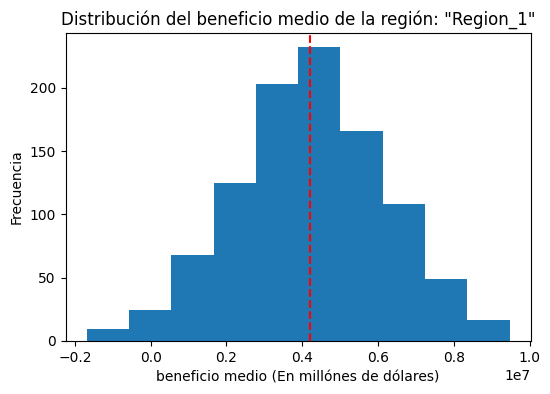

----------------------------------------------------

Region_2
Intervalo de confianza del 95% entre el rango de: 2740381.39 y 2866548.23  millones de dolares
Porcentaje de riesgo de pérdida : 0.7 %
Beneficio medio para la región 2803464.813


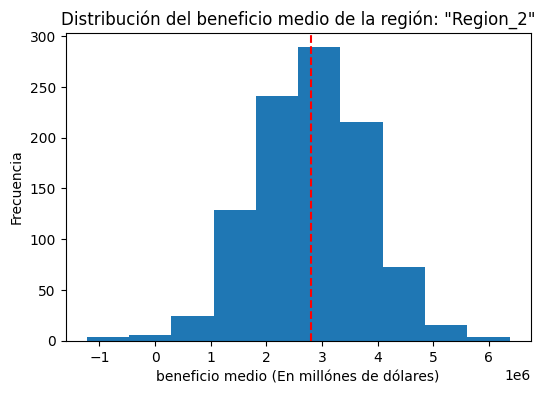

----------------------------------------------------


In [38]:
c=-1
#recorriendo los dataframes 
for df in [df_new_valid0,df_new_valid1,df_new_valid2]:
    
    c+=1
    region= 'Region_'+ str(c)
    region_profit= []
    
    #definiendo parámetros para realizar bootstrap
    bootstrap_reps = 1000
    sample_size= 500
    
    state = np.random.RandomState(123465)
    values= []

    values_interval =[]
    bootstrap_means=[]

    for i in np.arange(1,bootstrap_reps + 1):
        
        #Creando submuestra de tamaño sample_size
        subsample= df.sample(n=sample_size, replace=True ,  random_state = state)
        #calculando las ganancias para la submuestra
        profit = compute_gains(subsample)
        
        #guardando ganancias de cada submuestra en un arreglo
        region_profit.append(profit)


    #comparando si las ganancias fueron menores a 0 (pérdidas)
    values = [g < 0 for g in region_profit]

    
    #Calculando la  media de ganancias por región
    region_mean= np.mean(region_profit)
    
    #Calculando el riesgo de pérdida
    loss_risk =sum(values)/ len(values)
    
    values_interval = pd.Series(region_profit)
    
    #Calculando el intervalo de confianza del 95%
    standard_error =  st.sem(region_profit)
    intervalo = st.t.interval(0.95, len(region_profit)-1, loc=region_mean, scale=standard_error )


    print()
    print(region)
    
    print (f"Intervalo de confianza del 95% entre el rango de: {round(intervalo[0],2)} y {round(intervalo[1],2)}  millones de dolares", )
#     higher = values_interval.quantile(.975) 
#     lower = values_interval.quantile(.025) 
#     print(f"Intervalo de confianza del 95% : {round(lower,3)} -- {round(higher,3)} (Millones de dólares)")
    
    print(f"Porcentaje de riesgo de pérdida : {round(loss_risk*100, 3)} %" )
    print(f"Beneficio medio para la región {round(region_mean,3)}")
    
    plt.figure(figsize=[6,4])
    plt.hist(region_profit)
    plt.title(f'Distribución del beneficio medio de la región: "{region}"')
    plt.axvline(x=region_mean, color="red", ls="--")
    plt.xlabel('beneficio medio (En millónes de dólares)')
    plt.ylabel('Frecuencia')
    plt.show()
    
    print('----------------------------------------------------')


## Conclusiones

**Podemos observar conforme a los cálculos de riesgos y ganancia por región que:**
* La region 0 ('Region_0) es la que tiene menor riesgo de pérdida, presentando apenas un 0.1% de riesgo con una muestra de 500 pozos
* La región 1 ('Region_1) es la que tiene mayor riesgo de pérdida, presentando un 1.7% de riesgo con una muestra de 500 pozos

* La región 2 ('Región_2) presenta un riesgo medio en relación a las otras dos regiones, sin embargo el beneficio medio es el menor de los 3.

* Ninguna de las 3 regiones presenta un riesgo superior al 2.5% discriminatorio para esta tarea


Conforme a estos datos, las conclusiones y recomendaciones respecto a que zona considerar para la nueva inversión se ponen un poco a debate, esto debido a que si evaluamos exclusivamente por ganancias, la region_1 supera a la region_0 por 28% de ganancias, el equivalente a casi 930 mil dólares, sin embargo, tomando en cuenta el factor de riesgo, la region_1 tiene 17 veces más riesgo que la region_0 (0.1% vs 1.7%).


Por lo tanto, considerando que 930 mil dólares extras de la region_1, suponen un riesgo 17 veces mayor en relación a la region_0, la conclusión del equipo de ciencia de datos es:

**Se recomienda la inversión en la region_0 para los futuros proyectos.**

Recapitulando un poco los datos que nos ofrece la region_0:

**Region_0:**

* **Beneficio medio para la región 3,265,813.16**

* **Intervalo de confianza del 95% entre el rango de: 3,195,304.4 y 3,336,321.91  millones de dolares**

* **Porcentaje de riesgo de pérdida : 0.1 %**



